In [1]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


2025-05-05 14:55:04.611970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 14:55:04.614625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 14:55:04.623357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746449704.638697   31065 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746449704.642985   31065 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746449704.653471   31065 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [ ]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))


{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [ ]:
classnames = dataset.get_class_files("chainsaw")
print("Classes: ", classnames)
audio1 = AudioUtil.open(classnames[0])
audio2 = AudioUtil.open(classnames[1])
# print(classnames[0])
print(audio1)
AudioUtil.play(audio1)
import time
time.sleep(10200*5)
AudioUtil.play(audio2)


Classes:  [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Posix

In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


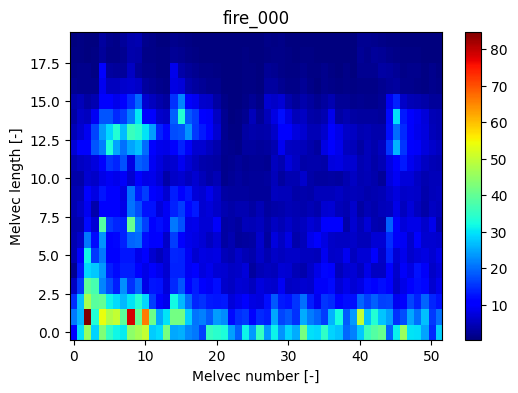

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


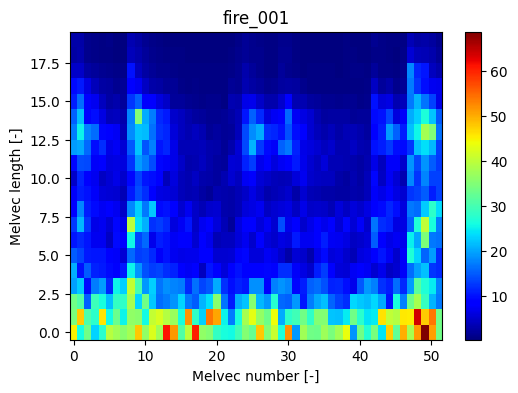

In [ ]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=2.5*950)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


idx = 0
myds.display(["fire", idx])
import time
time.sleep(2.5)
idx = 1
myds.display(["fire", idx])



Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [6]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
# print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
naudio_sum = sum(naudio.values())
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * naudio_sum, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")


Class names: ['chainsaw', 'fire', 'fireworks', 'gun']
Shape of the feature matrix : (273, 960)
Number of labels : 273
Class 'chainsaw': 80 samples
Class 'fire': 78 samples
Class 'fireworks': 75 samples
Class 'gun': 40 samples


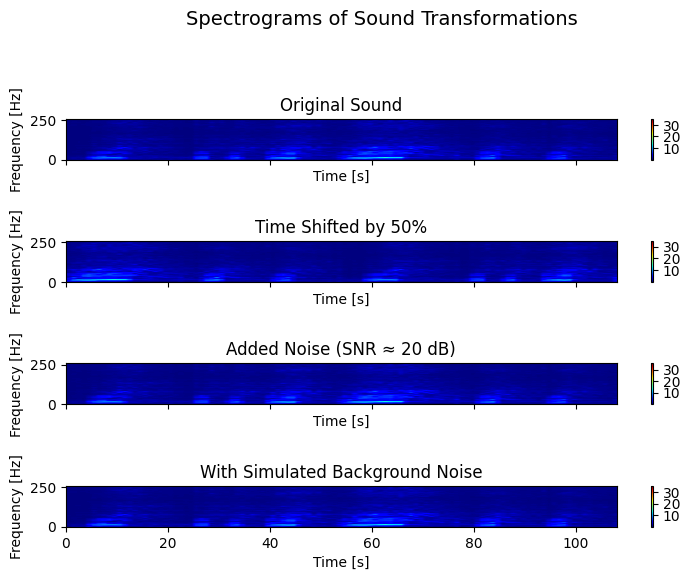

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
from typing import Tuple

def specgram(audio, Nft=512, fs2=11025) -> np.ndarray:
    """
    Compute a Spectrogram.

    :param audio: The audio signal as a tuple (signal, sample_rate).
    :param Nft: The number of points of the FFT.
    :param fs2: The target sampling frequency.
    """
    sig, sr = audio
    if sr != fs2:
        sig, _ = resample(audio, fs2)
        
    stft = librosa.stft(sig, n_fft=Nft, hop_length=Nft)
    
    return stft

def resample(audio, newsr=11025) -> Tuple[np.ndarray, int]:
    """
    Resample to target sampling frequency.

    :param audio: The audio signal as a tuple (signal, sample_rate).
    :param newsr: The target sampling frequency.
    """
    sig, sr = audio

    num_samples = int(len(sig) * newsr / sr)

    resig = scipy.signal.resample(sig, num_samples)

    return (resig, newsr)

def add_background_noise(audio, SNR=20):
    """
    Adds background noise from background.wav to audio at a given SNR.
    """
    sig, sr = audio
    bg_sig, _ = librosa.load("../src/classification/datasets/soundfiles/background.wav", sr=sr)

    sig_energy = np.mean(sig ** 2)
    bg_energy = np.mean(bg_sig ** 2)

    length = len(sig)
    start_index = np.random.randint(0, len(bg_sig) - length)
    bg_clip = bg_sig[start_index:start_index + length]

    factor = np.sqrt(sig_energy / (bg_energy * 10 ** (SNR / 10)))
    bg_clip *= factor
    mixed = sig + bg_clip
    mixed = np.clip(mixed, -1, 1)

    return mixed, sr

def plot_specgram(
    specgram,
    ax,
    is_mel=False,
    title=None,
    xlabel="Time [s]",
    ylabel="Frequency [Hz]",
    cmap="jet",
    cb=True,
    tf=None,
    invert=True,
    filename="specgram_plot.pdf"
):
    """
    Plot a spectrogram (2D matrix) in a chosen axis of a figure.
    Inputs:
        - specgram = spectrogram (2D array)
        - ax       = current axis in figure
        - title
        - xlabel
        - ylabel
        - cmap
        - cb       = show colorbar if True
        - tf       = final time in xaxis of specgram
    """
    if tf is None:
        tf = specgram.shape[1]

    if is_mel:
        ylabel = "Frequency [Mel]"
        im = ax.imshow(
            specgram, cmap=cmap, aspect="auto", extent=[0, tf, specgram.shape[0], 0]
        )
    else:
        im = ax.imshow(
            specgram,
            cmap=cmap,
            aspect="auto",
            extent=[0, tf, int(specgram.size / tf), 0],
        )
    if invert:
        ax.invert_yaxis()
    fig = plt.gcf()
    if cb:
        fig.colorbar(im, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.savefig(filename, format='pdf')
    return None

# Load original audio and normalize
path = "../src/classification/datasets/tmp_soundfiles/chainsaw_02.wav"
y, sr = librosa.load(path, sr=None)
y = y / np.max(np.abs(y))  # Normalize

# Time shift (50%)
time_shifted = np.roll(y, len(y) // 2)

# Add white noise (SNR ≈ 20 dB)
signal_power = np.mean(y ** 2)
snr = 10 ** (20 / 10)
noise_power = signal_power / snr
noise = np.random.normal(0, np.sqrt(noise_power), y.shape)
noisy = y + noise
noisy = np.clip(noisy, -1, 1)

# Add realistic background noise
with_background, _ = add_background_noise((y, sr), SNR=20)

# Compute spectrograms using custom specgram function
spec_original = specgram((y, sr))
spec_time_shifted = specgram((time_shifted, sr))
spec_noisy = specgram((noisy, sr))
spec_with_background = specgram((with_background, sr))

# Plotting Spectrograms using plot_specgram function with compact layout
fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True)  # Adjusted figsize for a more compact layout
fig.suptitle("Spectrograms of Sound Transformations", fontsize=14)

plot_specgram(np.abs(spec_original), axs[0], title="Original Sound", tf=spec_original.shape[1])
plot_specgram(np.abs(spec_time_shifted), axs[1], title="Time Shifted by 50%", tf=spec_time_shifted.shape[1])
plot_specgram(np.abs(spec_noisy), axs[2], title="Added Noise (SNR ≈ 20 dB)", tf=spec_noisy.shape[1])
plot_specgram(np.abs(spec_with_background), axs[3], title="With Simulated Background Noise", tf=spec_with_background.shape[1])

# Tighten layout further for compactness
plt.tight_layout(pad=2.0, h_pad=2.5, rect=[0, 0, 1, 0.96])  # Added pad and h_pad to reduce spacing
plt.show()
